In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd

import math
import scipy
import time
from scipy import special
from scipy import linalg

from tqdm import tqdm

import matplotlib
import random
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d

from sklearn.metrics import brier_score_loss, log_loss, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

import seaborn as sns
import torch
from torch import optim
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import LambdaLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

import argparse
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import DataLoader, DistributedSampler

import functools
import itertools
import operator
import os

In [2]:
# fix random seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# turn on cuDNN autotuner if your input sizes are fixed
torch.backends.cudnn.benchmark = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print("Number of GPUs available:", torch.cuda.device_count())
# for i in range(torch.cuda.device_count()):
#     print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

**Load Pep2Prob Dataset**

In [3]:
#############################################
# Load Data
#############################################

precursor_info_path = 'precursor_info.tsv'
matrix_path = 'matrix_mz_prob_mean_var.npy'
train_test_split_path0 = 'train_test_split_set_0.npy'

precursor_df = pd.read_csv(precursor_info_path, sep='\t')
# each row is a precursor, which is a pair of (peptide_sequence, charge)
# columns: [
#   'precursor_index',          # corresponds to the index of the first order of the matrix
#   'sequence',                 # peptide sequence, no modification by now
#   'charge',                   # charge of the precursor
#   'num_PSMs'                  # number of spectra that associated with this precursor
# ]

matrix = np.load(matrix_path)
# matrix is a 3D numpy array with shape (num_precursors, num_tokens_to_predict, 4)
#   num_precursors: the ith precursor corresponds to the ith row in precursor_df
#   num_tokens_to_predict: the number of tokens (peak) to predict in the ith precursor
#   4: for each token, there are 4 values: [
#       "m/z",                  # the m/z value of the token (peak)
#       "probability",          # the probability of the token (peak) to be observed
#       "mean_intensity",       # the mean intensity of the token (peak)
#       "var_intensity"         # the variance of the intensity of the token (peak)

train_test_split_set = np.load(train_test_split_path0, allow_pickle=True).item()

all_amino_acids = set(''.join(precursor_df['sequence'].tolist()))
amino_acids = sorted(list(all_amino_acids))
print(amino_acids)
len(precursor_df)

['A', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']


610117

In [4]:
precursor_df

,precursor_index,sequence,charge,num_PSMs,sequence_length,original_precursor_index
0,0,AAAAAAAAAAAAAAAGAGAGAK,2,1151,22,0
1,1,AAAAAAAAAAAAAAAASAGGK,2,25,21,1
2,2,AAAAAAAAAAAAAAAASAGGK,3,29,21,2
3,3,AAAAAAAAAAAAAAAGAGAGAK,3,1736,22,3
4,4,AAAAAAAAAAAAAAATAASAAASAILGGR,3,65,29,4
...,...,...,...,...,...,...
610112,610112,YYYWAVNPQDR,2,207,11,632069
610113,610113,YYYYER,2,48,6,632070
610114,610114,YYYYHR,3,517,6,632071
610115,610115,YYYYMWK,2,38,7,632072


**Define the Ion Mask**

In [5]:
def get_ion_mask(seq_len, charge, max_seq_len=50):
    # a2+ ions
    mask = [True]
    # b/y ions with charge 1/2/3
    for ion in range(1, 3):
        for chr in range(1, 4):
            if chr > charge:
                for seq_idx in range(1, max_seq_len):
                    mask.append(False)
            else:
                for seq_idx in range(1, max_seq_len):
                    if seq_idx < seq_len:
                        mask.append(True)
                    else:
                        mask.append(False)
    return mask

In [6]:
#############################################
# Setup Vocabulary and Tokenization
#############################################
special_tokens = ["[PAD]", "[CLS]", "[CHARGE]", "[OUTPUT]"]
all_tokens = special_tokens + amino_acids
token_to_id = {t: i for i, t in enumerate(all_tokens)}
PAD_ID = token_to_id["[PAD]"]
CLS_ID = token_to_id["[CLS]"]
CHARGE_ID = token_to_id["[CHARGE]"]
OUTPUT_ID = token_to_id["[OUTPUT]"]

def encode_peptide(seq):
    return [token_to_id[aa] for aa in seq if aa in token_to_id]

def encode_input(seq, charge, max_length_input):
    # Represent charge by repeating the [CHARGE] token 'charge' times
    charge_tokens = [CHARGE_ID]*charge
    input_ids = [CLS_ID] + encode_peptide(seq) + charge_tokens + [OUTPUT_ID]
    # Pad input if necessary
    if len(input_ids) > max_length_input:
        input_ids = input_ids[:max_length_input]
    else:
        input_ids += [PAD_ID]*(max_length_input - len(input_ids))
    return input_ids

In [7]:
class MS2Dataset(Dataset):
    def __init__(self, df, matrix_data, max_length_input=40):
        # Precursor, which is a pair of (peptide_sequence, charge)
        self.df = df.reset_index(drop=True)
        self.matrix_data = matrix_data
        # Maximal length of peptide_sequence + charge state
        self.max_length_input = max_length_input
        # We need to know output length = num_tokens_to_predict from data
        # Assume that we predict all the probabilities for all irons although most of them are zeros
        self.output_length = self.matrix_data.shape[1]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        seq = self.df.loc[idx, 'sequence']
        charge = self.df.loc[idx, 'charge']

        input_ids = encode_input(seq, charge, self.max_length_input)
        input_ids = torch.tensor(input_ids, dtype=torch.long)

        ion_mask = get_ion_mask(len(seq), charge,self.max_length_input)

        # matrix_data[idx]: shape [output_length, 4]
        # Columns: [m/z, probability, mean_intensity, var_intensity]
        # We only predict probability (index 1) right now
        row = self.matrix_data[idx]  # shape [output_length, 4]
        probability = row[:, 1]  # shape [output_length, 1]

        probability = torch.tensor(probability, dtype=torch.float)

        # Combined input: input length + output_length
        combined_input = torch.cat([input_ids, torch.full((self.output_length,), PAD_ID, dtype=torch.long)])

        # Find OUTPUT token and get its position
        output_pos_tensor = (combined_input == OUTPUT_ID).nonzero(as_tuple=True)[0]
        output_pos = output_pos_tensor.item() if output_pos_tensor.numel() > 0 else -1  # Assign -1 if not found

        return combined_input, probability, output_pos, torch.BoolTensor(ion_mask)

**Transformer Model**

In [8]:
#############################################
# Model Decoder-only Transformer
#############################################
class DecoderOnlyTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=256, nhead=4, num_layers=4, dim_feedforward=512, max_len=300, pad_id=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_id)
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len, d_model))

        layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward,dropout=0.2)
        self.decoder = nn.TransformerDecoder(layer, num_layers=num_layers)

        # Output head: probability
        self.output_head = nn.Linear(d_model, 1)

        self.max_len = max_len
        self.d_model = d_model

    def forward(self, input_ids):
        B, L = input_ids.size()
        x = self.embedding(input_ids) + self.pos_embedding[:, :L, :]  # [B, L, D]

        tgt_mask = self._generate_square_subsequent_mask(L).to(input_ids.device)

        x = x.permute(1, 0, 2)
        out = self.decoder(tgt=x, memory=x, tgt_mask=tgt_mask)
        out = out.permute(1, 0, 2)  # [B, L, D]

        preds = self.output_head(out)  # [B, L, 2]
        return preds

    def _generate_square_subsequent_mask(self, sz):
        mask = torch.full((sz, sz), float('-inf'))
        mask = torch.triu(mask, diagonal=1)
        return mask

**Train/test split**

In [9]:
#############################################
#  Train/test Data
#############################################
N = len(precursor_df)
print("Total number of precursors:", N)
train_indices = train_test_split_set['train_indices']
test_indices = train_test_split_set['test_indices']

train_df = precursor_df.iloc[train_indices].reset_index(drop=True)
test_df = precursor_df.iloc[test_indices].reset_index(drop=True)
train_matrix = matrix[train_indices]
test_matrix = matrix[test_indices]

print("Train size:", len(train_df))
print("Test size:", len(test_df))

Total number of precursors: 610117
Train size: 497197
Test size: 132260


In [10]:
max_length_input = 40
batch_size = 512

#############################################
# Create training and test Dataset Loaders
#############################################

train_dataset = MS2Dataset(train_df, train_matrix, max_length_input=max_length_input)
test_dataset = MS2Dataset(test_df, test_matrix, max_length_input=max_length_input)

train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size,     # you may want to scale this up (e.g. 4×) now that you have 4 GPUs
    shuffle    = True,
    num_workers= 4,
    pin_memory = True
)

test_loader = DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle    = False,
    num_workers= 0,
    pin_memory = False
)

output_length = train_dataset.output_length
max_len = max_length_input + output_length

**Set up transformer model**

In [11]:
d_model = 180
lr = 0.001
epochs = 2

model = DecoderOnlyTransformer(vocab_size=len(all_tokens), d_model=d_model, max_len=max_len)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model = model.to(device)
criterion = nn.L1Loss(reduction='none')
MSE_loss = torch.nn.MSELoss(reduction='none')


optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',       # we want val loss to go down
    factor=0.5,       # cut LR in half on plateau
    patience=5,       # wait 5 epochs with no improvement
    min_lr=1e-6       # never go below this LR
)

# metric histories
train_losses = []
test_losses = []
mse_list = []

print("Total number of parameters:",sum(p.numel() for p in model.parameters() if p.requires_grad))


Total number of parameters: 1840749


**Training and Evaluation loops**

In [12]:
#############################################
# Training & Evaluation Loop
#############################################
for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    running_train_loss = 0.0
    for batch in tqdm(train_loader):
        input_batch, target_batch, output_pos_batch, ion_mask_batch = batch
        input_batch = input_batch.to(device, non_blocking=True)
        target_batch = target_batch.to(device, non_blocking=True)
        output_pos_batch = output_pos_batch.to(device, non_blocking=True)

        preds = model(input_batch)  # [B, L, 1]

        B, L, _ = preds.size()
        # Create mask for output positions
        mask = torch.zeros(B, L, dtype=torch.bool, device=preds.device)
        for i in range(B):
            start_idx = output_pos_batch[i].item() + 1
            end_idx = start_idx + output_length
            mask[i, start_idx:end_idx] = True

        preds_output = torch.sigmoid(preds[mask].view(B, output_length,1))
        ion_mask_batch = ion_mask_batch.float().view(B, output_length,1).to(device)
        per_token_loss = criterion(preds_output, target_batch.view(B, output_length, 1))
        masked_loss  = per_token_loss * ion_mask_batch
        loss_sum_per_sample = masked_loss.sum(dim=(1,2))
        n_valid_per_sample = ion_mask_batch.sum(dim=(1,2))
        per_sample_loss = loss_sum_per_sample / (n_valid_per_sample + 1e-8)
        loss = per_sample_loss.mean()
        # loss = loss.mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluation
    model.eval()
    running_test_loss = 0.0
    mse_total        = 0.0

    with torch.no_grad():
        for input_ids, target, out_pos, ion_mask in test_loader:
            # Move everything once
            input_ids = input_ids.to(device, non_blocking=True)
            target    = target.to(device,    non_blocking=True)
            out_pos   = out_pos.to(device,   non_blocking=True)
            # shape: [B, output_length]
            ion_mask = ion_mask.to(device).float().unsqueeze(-1)  # [B, O, 1]

            # 1) Forward + sigmoid
            logits = model(input_ids)                # [B, L, 1]
            probs  = torch.sigmoid(logits)           # [B, L, 1]
            B, L, _ = probs.shape

            # 2) Build a [B, L] boolean mask of “where we predict ions”
            positions = torch.arange(L, device=device).unsqueeze(0)     # [1, L]
            start     = (out_pos + 1).unsqueeze(1)                      # [B, 1]
            valid_pos = (positions >= start) & (positions < start + output_length)  # [B, L]
            valid_pos = valid_pos.unsqueeze(-1)                        # [B, L, 1]

            # 3) Slice out exactly the O prediction spots
            preds_out = probs[valid_pos].view(B, output_length, 1)     # [B, O, 1]
            targ_out  = target.view(B, output_length, 1)

            # 4) Per-token absolute and squared errors
            abs_err = (preds_out - targ_out).abs()                     # [B, O, 1]
            sq_err  = (preds_out - targ_out).pow(2)                    # [B, O, 1]

            # 5) Apply your ion mask
            abs_err = abs_err * ion_mask
            sq_err  = sq_err  * ion_mask

            # 6) Sum over tokens → one loss per sample
            sum_abs = abs_err.sum(dim=(1,2))                           # [B]
            sum_sq  = sq_err.sum(dim=(1,2))                            # [B]
            cnt     = ion_mask.sum(dim=(1,2)).clamp(min=1e-8)          # [B]

            loss_per_sample = sum_abs / cnt                            # [B]
            mse_per_sample  = sum_sq  / cnt                            # [B]

            # 7) Average over the batch
            running_test_loss += loss_per_sample.mean().item()
            mse_total        += mse_per_sample.mean().item()

    # Final averages
    avg_test_loss = running_test_loss / len(test_loader)
    avg_mse       = mse_total        / len(test_loader)
    test_losses.append(avg_test_loss)
    mse_list.append(avg_mse)
    # Print results
    print(f"Training MAE: {avg_train_loss:.4f}, Test MAE: {avg_test_loss:.4f}, MSE: {avg_mse:.4f}")
    # 1) Step the ReduceLROnPlateau scheduler
    scheduler.step(avg_test_loss)

    # 2) (Optional) log the updated LR
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}: val_loss={avg_test_loss:.4f}, lr={current_lr:.2e}")
    if (epoch + 1) % 4 == 0:
        torch.save(
            model.state_dict(),
            f"checheckpoint_path0_epoch{epoch+1:02d}.pth"
        )

 50%|█████     | 1/2 [07:12<07:12, 432.47s/it]

Training MAE: 0.1312, Test MAE: 0.1026, MSE: 0.0444
Epoch 1: val_loss=0.1026, lr=1.00e-03



100%|██████████| 2/2 [14:22<00:00, 431.08s/it]

Training MAE: 0.1017, Test MAE: 0.0930, MSE: 0.0378
Epoch 2: val_loss=0.0930, lr=1.00e-03


**Save Model and outputs**

In [13]:
#########################################################################
torch.save(
    model.state_dict(),
    f"checkpoint_path0_epoch{epoch+1:02d}.pth"
)
# Save the losses
np.save("train_losses_path0.npy", train_losses)
np.save("test_losses_path0.npy", test_losses)
np.save("mse_list_path0.npy", mse_list)

model.eval()
all_preds = []
total_dataset = MS2Dataset(precursor_df, matrix, max_length_input=max_length_input)
total_loader = DataLoader(
    total_dataset,
    batch_size = batch_size,     # you may want to scale this up (e.g. 4×) now that you have 4 GPUs
    shuffle    = False,
    num_workers= 1,
    pin_memory = True
)
with torch.no_grad():
    for input_batch, _, output_pos_batch, _ in tqdm(total_loader):
        # Move to GPU/CPU
        input_batch      = input_batch.to(device)
        output_pos_batch = output_pos_batch.to(device)

        # 1) Forward pass
        logits = model(input_batch)         # [B, L, 1]
        probs  = torch.sigmoid(logits)      # [B, L, 1]
        probs  = probs.squeeze(-1)          # [B, L]

        B, L = probs.shape
        # 2) build a [B,L] mask that picks out the output_length tokens after [OUTPUT]
        positions = torch.arange(L, device=probs.device).unsqueeze(0)  # [1, L]
        start     = (output_pos_batch.unsqueeze(1) + 1)               # [B, 1]
        end       = start + output_length                             # [B, 1]
        select_mask = (positions >= start) & (positions < end)        # [B, L]

        # 3) for each sample i, pick its slice of length output_length
        #    and stack them into a [B, output_length] tensor
        batch_preds = torch.stack([
            probs[i, select_mask[i]]
            for i in range(B)
        ], dim=0)  # [B, output_length]

        all_preds.append(batch_preds.cpu())

all_preds = torch.cat(all_preds, dim=0).numpy()
# 5) save to file
np.save("predictions_path0.npy", all_preds)



100%|██████████| 1192/1192 [03:01<00:00,  6.56it/s]


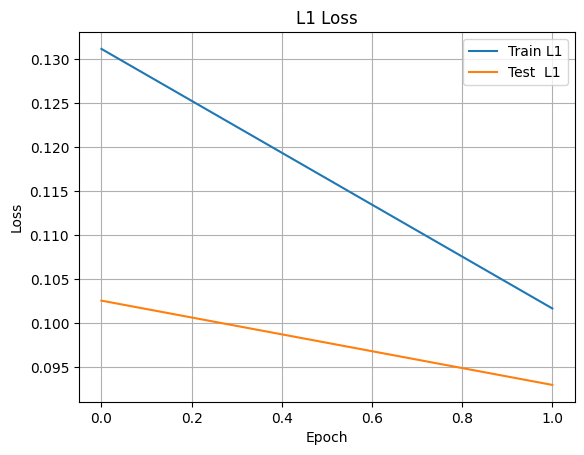

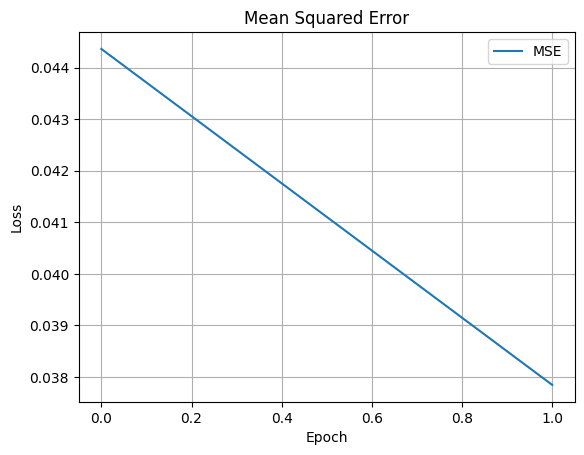

In [14]:
# set up one figure per metric
fig_l1, ax_l1 = plt.subplots()
fig_mse, ax_mse = plt.subplots()

ax_l1.plot(train_losses, label="Train L1")
ax_l1.plot(test_losses,  label="Test  L1")
ax_l1.set_title("L1 Loss")
ax_l1.legend()
ax_l1.set_xlabel("Epoch")
ax_l1.set_ylabel("Loss")
ax_l1.grid()
fig_l1.savefig("l1_loss_path0.png")
ax_mse.plot(mse_list, label="MSE")
ax_mse.set_title("Mean Squared Error")
ax_mse.legend()
ax_mse.set_xlabel("Epoch")
ax_mse.set_ylabel("Loss")
ax_mse.grid()
fig_mse.savefig("mse_path0.png")